# 📊 Portfolio Construction Approaches: Black–Litterman, Risk Parity, and Kelly Criterion: general introduction

This notebook takes forward the implementations and performs stress testing on the Black-Litterman approach to check the effect of various scenarios

---

- **Black–Litterman (BL)**
- **Risk Parity (Equal Risk Contribution)**
- **Kelly Criterion (quadratic approximation)**

---

## 1. Black–Litterman (BL)

### Idea
- A Bayesian portfolio optimization framework developed at Goldman Sachs.  
- Combines:
  - **Market equilibrium returns** (implied from CAPM or benchmark weights).  
  - **Investor views** (absolute or relative return forecasts).  
- Produces adjusted expected returns (`bl_returns`) and a covariance matrix (`bl_cov`) that reflect both the prior and subjective beliefs.  

### Benefits
- Avoids the **extreme weights** of pure mean–variance optimization (MVO).  
- Lets you **incorporate views systematically** (e.g., “Tech will outperform Bonds by 2%”).  
- Smooths estimation error by blending market priors with forecasts.  

### When to use
- You have **subjective views** (quant models, analyst forecasts, factor tilts).  
- You want a **bridge between passive and active** management.  
- Best when your beliefs are **uncertain** and you want to weight them against priors.  

---

## 2. Risk Parity (Equal Risk Contribution, ERC)

### Idea
- Ignore expected returns (`mu`) and focus on **risk allocation**.  
- Each asset contributes equally to portfolio risk (volatility).  
- Example: in a two-asset portfolio, if bonds are less volatile than equities, risk parity will overweight bonds to equalize contributions.  

### Benefits
- **Robust and stable**: avoids reliance on noisy expected returns.  
- Naturally produces **diversified portfolios**.  
- Performs well in **multi-asset, diversified strategies** (popular in hedge funds like Bridgewater’s *All Weather*).  

### When to use
- When you **don’t trust return forecasts** but trust risk models (covariance).  
- Strategic asset allocation / **core** portfolio.  
- **Risk-first investors**: pensions, endowments, conservative mandates.  
- In high-uncertainty environments (e.g., crises).  

---

## 3. Kelly Criterion (Quadratic Approximation)

### Idea
- The Kelly strategy maximizes **expected log growth rate** of wealth.  
- Quadratic approximation (convex form):  
  $w^* = \arg\max_w \ \mu^T w - \tfrac{1}{2} w^T \Sigma w$
- Aggressive: seeks **long-term capital growth**, assuming return estimates (`mu`) are accurate.  

### Benefits
- **Optimal in theory**: maximizes compounding growth rate.  
- Encourages **leverage scaling** (full Kelly vs fractional Kelly).  
- Useful for **active traders** or strategies with strong forecasts.  

### When to use
- When you have **highly reliable expected return estimates** (e.g., factor models, trading signals).  
- In **active trading** where long-run compounding is key.  
- Use **fractional Kelly (e.g., 0.5x)** to reduce drawdown risk.  

---

## 🔄 Comparison

| Method             | Uses Expected Returns? | Uses Covariance? | Key Feature                   | Best When                                    |
|--------------------|------------------------|------------------|-------------------------------|----------------------------------------------|
| **Black–Litterman** | ✅ (blended with views) | ✅               | Incorporates subjective views | You have forecasts but want to regularize     |
| **Risk Parity**    | ❌ (ignores `mu`)      | ✅               | Equalizes risk contributions  | You distrust return forecasts                 |
| **Kelly**          | ✅ (very sensitive)    | ✅               | Maximizes log-growth          | You have strong and reliable forecasts        |

---

## 🚀 Practical Takeaways

- **Risk Parity** → if you want diversification without betting on forecasts.  
- **Black–Litterman** → if you want to blend market consensus with your own insights.  
- **Kelly** → if you want aggressive growth and have high-confidence signals.  

**In practice**:  
- Many institutions combine these approaches.  
  - Use **Risk Parity** for the “core” diversified allocation.  
  - Apply **Black–Litterman** for tactical tilts.  
  - Use **Kelly sizing** for high-alpha strategies.  


In [17]:
!pip install PyPortfolioOpt --quiet
!pip install cvxpy --quiet
!pip install riskfolio-lib --quiet
!pip install mlfinlab --quiet

ERROR: Could not find a version that satisfies the requirement mlfinlab (from versions: none)
ERROR: No matching distribution found for mlfinlab


In [18]:
# -----------------------------
# Imports
# -----------------------------

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.optimize import minimize
import cvxpy as cp

from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
#from pypfopt.black_litterman import BlackLittermanModel
from pypfopt import EfficientFrontier
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.black_litterman import BlackLittermanModel, market_implied_risk_aversion


from pypfopt import (
    risk_models,
    expected_returns,
)


Reliance        (has the ticker): RELIANCE.NS                   
TCS             (has the ticker): TCS.NS                        
Infosys         (has the ticker): INFY.NS                       
HDFC Bank       (has the ticker): HDFCBANK.NS                   
ICICI Bank      (has the ticker): ICICIBANK.NS                  
Hindustan Unilver (has the ticker): HINDUNILVR.NS                 
Larsen&Turbo    (has the ticker): LT.NS                         
Axis gold ETF   (has the ticker): AXISGOLD.NS                   
S&P 500 ETF     (has the ticker): ^GSPC                         
Bharat 22 ETF   (has the ticker): ICICIB22.NS                   
Bharat Bond     (has the ticker): EBBETF0430.NS                 
LT Govt. Bond   (has the ticker): LTGILTBEES.NS                 
Bitcoin         (has the ticker): BTC-USD                       
Ethereum        (has the ticker): ETH-USD                       


/tmp/ipython-input-4252757458.py:52: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_df = price_df.pct_change().dropna()


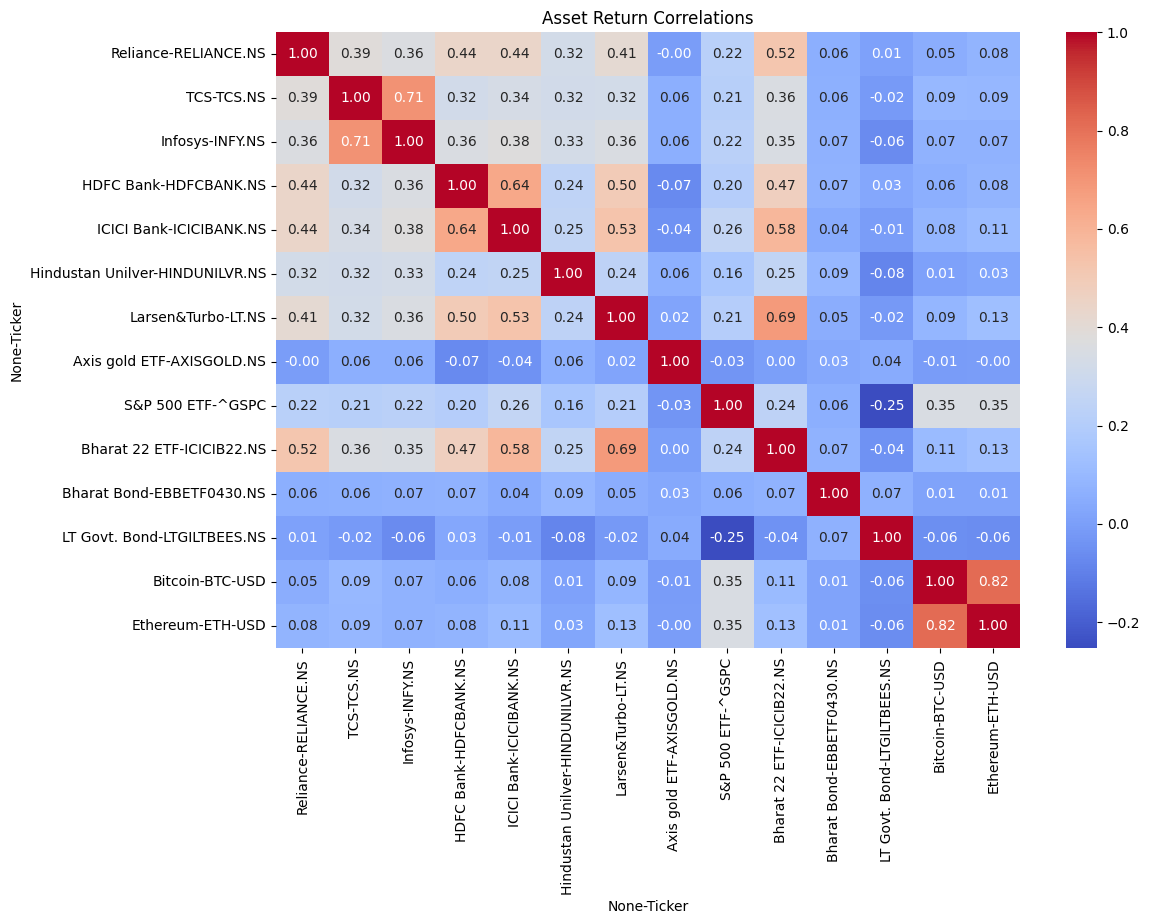

In [19]:
# Dictionary of Indian market assets
assets = {
    "Reliance": "RELIANCE.NS",   # Reliance Industries
    "TCS": "TCS.NS",        # Tata Consultancy Services
    "Infosys":"INFY.NS",       # Infosys
    "HDFC Bank":"HDFCBANK.NS",   # HDFC Bank
    "ICICI Bank":"ICICIBANK.NS",  # ICICI Bank
    "Hindustan Unilver":"HINDUNILVR.NS", # Hindustan Unilever
    "Larsen&Turbo":"LT.NS",         # Larsen & Toubro
    "Axis gold ETF":"AXISGOLD.NS",   # Axis Gold ETF
    "S&P 500 ETF":"^GSPC",         # S&P 500 (international diversification)
    "Bharat 22 ETF":"ICICIB22.NS",   # BHARAT 22 ETF
    "Bharat Bond":"EBBETF0430.NS", # The Bharat Bond ETF
    "LT Govt. Bond": "LTGILTBEES.NS", # Long term govt. bonds
    #"Volatility index":"^INDIAVIX", # India volatility index(excluding as not investable directly)
    "Bitcoin": "BTC-USD", # Crypto: Bitcoin
    "Ethereum": "ETH-USD", # Crypto: Ethereum
}


for name, ticker in assets.items():
  print(f'{name:15} (has the ticker): {ticker:30}')

# -----------------------------
# Assets to Analyze
# -----------------------------
#assets = assets

start_date = '2018-01-01'
end_date = '2024-12-31'

# -----------------------------
# Download Data
# -----------------------------
series_dict = {}
for name, ticker in assets.items():
    df = yf.download(ticker, start=start_date, end=end_date, progress=False, auto_adjust=False)
    if not df.empty and 'Adj Close' in df.columns:
        series_dict[name] = df['Adj Close']
    else:
        print(f"⚠️ Skipped {name} ({ticker}) - no data returned")

# -----------------------------
# Build Price DataFrame
# -----------------------------
if not series_dict:
    raise ValueError("No valid data downloaded. Please check tickers.")

price_df = pd.concat(series_dict, axis=1)

# Daily returns
returns_df = price_df.pct_change().dropna()

# Check the first few rows
returns_df.head()

plt.figure(figsize=(12,8))
sns.heatmap(returns_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Asset Return Correlations")
plt.show()


# 📈 Results & Analysis

### **Train/Test split**: weights optimized on training, evaluated Out-of-Sample (OOS).

---

Expected annual return: 26.0%
Annual volatility: 6.7%
Sharpe Ratio: 3.60
Falling back to scipy risk parity solver (stable).

=== Portfolio Performance Comparison ===
                 Expected Return  Volatility  Sharpe Ratio
Black-Litterman           0.2599      0.0666        3.6005
Risk Parity               0.1325      0.1247        0.9023
Kelly                     0.1711      0.1798        0.8404


/tmp/ipython-input-1594925912.py:61: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_df_train = price_df_train.pct_change().dropna()
/tmp/ipython-input-1594925912.py:62: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_df_test = price_df_test.pct_change().dropna()
/usr/local/lib/python3.12/dist-packages/pypfopt/expected_returns.py:32: UserWarning: Some returns are NaN. Please check your price data.
  warnings.warn(


<Figure size 1400x600 with 0 Axes>

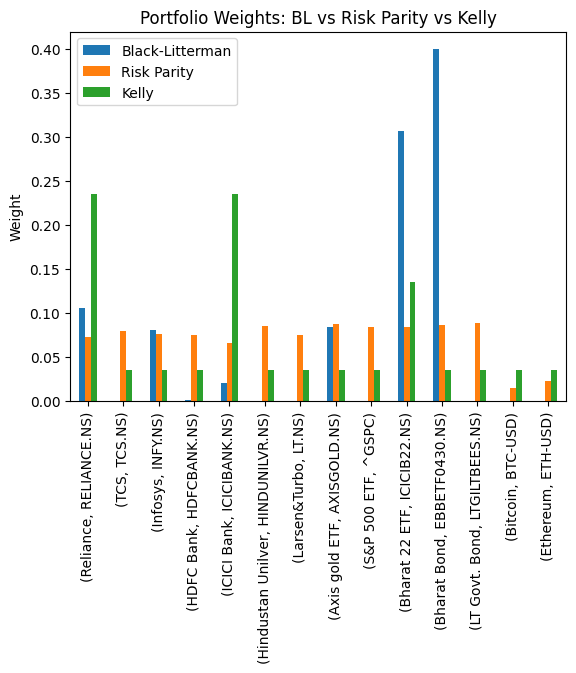

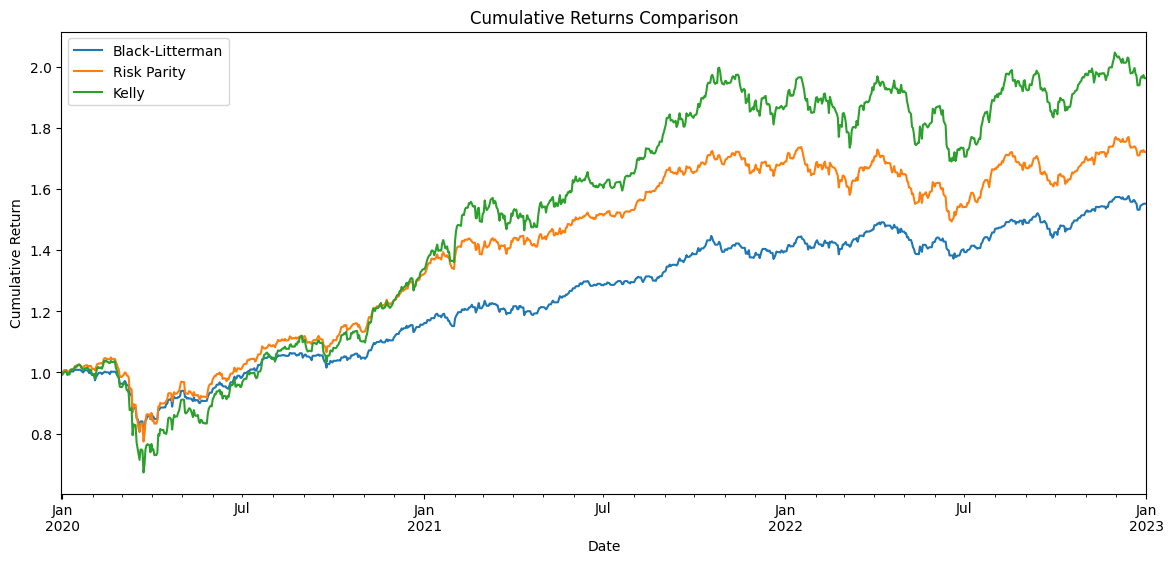


=== Out-of-Sample Performance (Test Period) ===
                   CAGR  Ann. Vol  Sharpe  Max Drawdown  Ending Value
Strategy                                                             
Black-Litterman  0.1766    0.0656  2.3880       -0.0526        1.3816
Risk Parity      0.1851    0.0693  2.3806       -0.0463        1.4015
Kelly            0.2187    0.0962  2.0651       -0.0650        1.4816


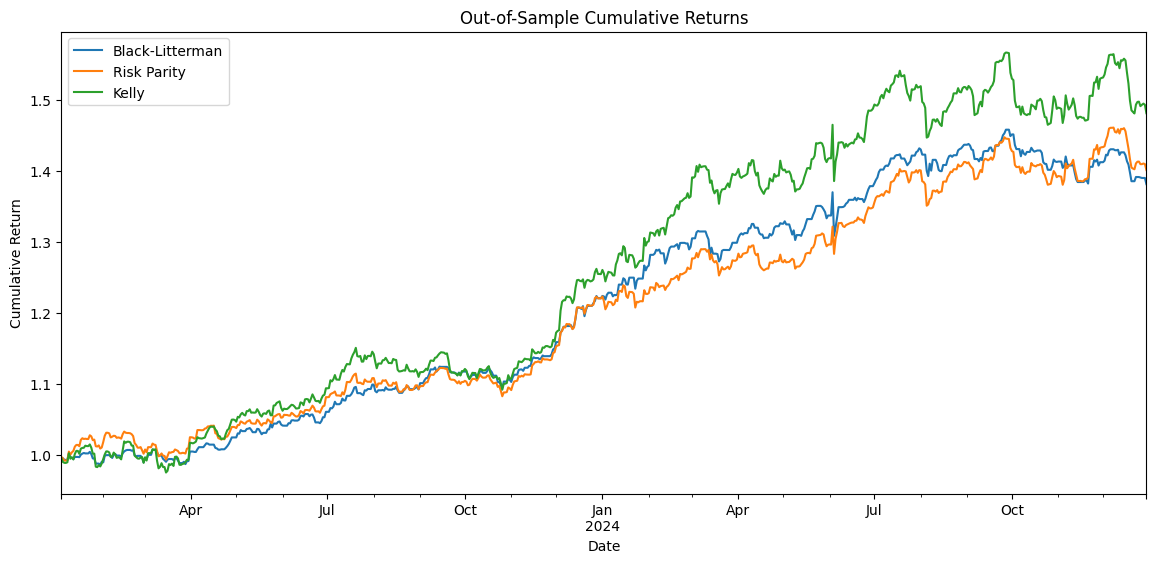

In [20]:
# Optional libraries (wrapped later)
try:
    import riskfolio as rp_lib
except Exception:
    rp_lib = None

try:
    # mlfinlab's API can change across versions; we'll attempt an import
    import mlfinlab as ml
    from mlfinlab.portfolio_optimization import hierarchical_risk_parity as ml_hierarchical_rp
except Exception:
    ml = None
    ml_hierarchical_rp = None

# -----------------------------
#  Helper: portfolio_performance_oos (unchanged)
# -----------------------------
def portfolio_performance_oos(returns_df_test, weights, freq=252, rf_rate=0.02):
    """Compute OOS realized performance given fixed weights and test-period returns."""
    weights_series = pd.Series(weights).reindex(returns_df_test.columns).fillna(0.0)
    port_daily = returns_df_test.dot(weights_series)

    cum = (1 + port_daily).cumprod()
    ending_value = cum.iloc[-1]

    days = (cum.index[-1] - cum.index[0]).days
    years = days / 365.25

    cagr = ending_value ** (1 / years) - 1 if ending_value > 0 else np.nan
    ann_vol = port_daily.std() * np.sqrt(freq)
    sharpe = (cagr - rf_rate) / ann_vol if ann_vol > 0 else np.nan

    running_max = cum.cummax()
    drawdown = (cum - running_max) / running_max
    max_dd = drawdown.min()

    return {
        "CAGR": cagr,
        "Ann. Volatility": ann_vol,
        "Sharpe": sharpe,
        "Max Drawdown": max_dd,
        "Ending Value": ending_value,
        "Cumulative Series": cum
    }

# -----------------------------
#  STEP 2 (unchanged): Black-Litterman
# -----------------------------

# -----------------------------
# STEP 1: Data Preparation
# -----------------------------
# -----------------------------
# Example Usage
# -----------------------------
# Split your price_df into train/test
split_date = "2023-01-01"   # choose your cutoff
price_df_train = price_df.loc[:split_date]
price_df_test = price_df.loc[split_date:]

returns_df_train = price_df_train.pct_change().dropna()
returns_df_test = price_df_test.pct_change().dropna()


# -----------------------------
# STEP 1: Data Preparation
# -----------------------------
# Example: price_df = pd.DataFrame(...) with daily asset prices
#returns_df = price_df.pct_change().dropna()
returns_df = returns_df_train
price_df = price_df_train

# Annualized expected returns (prior, Pi)
pi = mean_historical_return(price_df, frequency=252)

# Covariance matrix (shrunk)
S = CovarianceShrinkage(price_df).ledoit_wolf()

# Annualized volatility
volatility = returns_df.std() * np.sqrt(252)

# Risk-free rate for Sharpe
rf_rate = 0.02

# Weight constraints
w_min, w_max = 0.0, 0.4

# -----------------------------
# STEP 2: Black-Litterman
# -----------------------------
absolute_views = pi.to_dict()
scaling_factor = 0.5
Omega = np.diag((volatility[absolute_views.keys()] * scaling_factor)**2)
tau = 0.2

bl = BlackLittermanModel(S, pi=pi, absolute_views=absolute_views, tau=tau, omega=Omega)
bl_returns = bl.bl_returns()
bl_cov = bl.bl_cov()

ef_bl = EfficientFrontier(bl_returns, bl_cov, weight_bounds=(w_min, w_max))
weights_bl = ef_bl.max_sharpe(risk_free_rate=rf_rate)
weights_bl = ef_bl.clean_weights()

perf_bl = ef_bl.portfolio_performance(verbose=True, risk_free_rate=rf_rate)

# -----------------------------
#  New: CVXPY-based Kelly (robust quadratic Kelly approximation)
# -----------------------------
def kelly_cvxpy(mu, cov_matrix, weight_bounds=(0.0, 0.4), leverage=1.0, solver=cp.OSQP):
    """
    Solve max(mu^T w - 0.5 * w^T Sigma w) subject to sum(w)=1 and bounds.
    This is a quadratic approximation to a Kelly/log-utility objective and is convex.
    """
    mu = np.asarray(mu).flatten()
    Sigma = np.asarray(cov_matrix)
    n = len(mu)

    w = cp.Variable(n)

    objective = cp.Maximize(mu @ w - 0.5 * cp.quad_form(w, Sigma))
    constraints = [
        cp.sum(w) == 1,
        w >= weight_bounds[0],
        w <= weight_bounds[1]
    ]
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=solver, verbose=False)

    if w.value is None:
        raise RuntimeError("CVXPY failed to find a solution for Kelly (try another solver).")
    w_opt = np.array(w.value).flatten()
    # Apply leverage as scaling of net exposures while keeping budget constraint:
    # If leverage != 1, rescale deviations from a baseline; simplest: scale weights linearly
    # and re-normalize to sum to 1 (preserve budget constraint). Here we treat leverage
    # as fractional Kelly (0 < leverage <= 1) by shrinking toward equal-weighted baseline:
    if leverage != 1.0:
        baseline = np.ones(n) / n
        w_scaled = leverage * w_opt + (1 - leverage) * baseline
        # enforce bounds
        w_scaled = np.clip(w_scaled, weight_bounds[0], weight_bounds[1])
        w_scaled = w_scaled / np.sum(w_scaled)
        return w_scaled
    else:
        # ensure numerical normalization
        w_opt = np.clip(w_opt, weight_bounds[0], weight_bounds[1])
        w_opt = w_opt / np.sum(w_opt)
        return w_opt

# -----------------------------
#  New: Improved Risk Parity using SciPy (stable fallback)
# -----------------------------
def _risk_contribution(weights, cov_matrix):
    port_var = weights.T @ cov_matrix @ weights
    # component risk (variance contribution)
    marginal = cov_matrix @ weights
    # contribution to variance (not normalized by sqrt); consistent target can be equalized
    # For equal risk contributions in volatility terms we can use: w_i * (Σw)_i
    return weights * marginal

def risk_parity_scipy(cov_matrix, bounds=(0.0, 0.4), tol=1e-9):
    """
    Find equal risk contribution (variance-contribution) weights via scipy minimize.
    This minimizes squared differences of variance contributions (w*(Σw)).
    """
    n = cov_matrix.shape[0]
    initial = np.ones(n) / n
    bounds_list = [bounds] * n

    def objective(w):
        # ensure numerical stability
        w = np.maximum(w, 1e-12)
        rc = _risk_contribution(w, cov_matrix)
        # target is equal contributions: mean of rc
        target = np.mean(rc)
        return np.sum((rc - target) ** 2)

    constraints = [
        {"type": "eq", "fun": lambda w: np.sum(w) - 1.0}
    ]

    result = minimize(objective, initial, method='SLSQP', bounds=bounds_list, constraints=constraints, tol=tol, options={'maxiter': 1000})
    if not result.success:
        # Try a more robust approach (trust-constr)
        result = minimize(objective, initial, method='trust-constr',
                          bounds=bounds_list,
                          constraints=constraints,
                          options={'maxiter': 2000})
    if not result.success:
        raise RuntimeError("Risk parity optimization failed: " + str(result.message))
    w_opt = result.x
    # numerical cleaning
    w_opt = np.maximum(w_opt, 0)
    w_opt = w_opt / np.sum(w_opt)
    return w_opt

# -----------------------------
#  Optional: riskfolio-lib route (if installed)
# -----------------------------
def risk_parity_riskfolio(returns_df, w_min=0.0, w_max=0.4):
    """
    Use riskfolio-lib to compute Risk Parity if installed. The API below is a common usage pattern,
    but check your installed version of riskfolio-lib for exact function names and parameters.
    """
    if rp_lib is None:
        raise ImportError("riskfolio-lib not installed.")
    port = rp_lib.Portfolio(returns=returns_df)
    # compute statistics (use historical returns and Ledoit-Wolf shrinkage)
    port.assets_stats(method_mu='hist', method_cov='ledoit')
    # rp_optimization has a few options; the call below is one typical signature.
    w = port.rp_optimization(model='Classic', rm='MV', rf=0, bnds=(w_min, w_max))
    # rp_optimization could return a DataFrame or Series depending on version; coerce to numpy
    if isinstance(w, (pd.Series, pd.DataFrame)):
        w = w.squeeze().values
    return np.array(w)

# -----------------------------
#  Optional: mlfinlab HRP route (if installed)
# -----------------------------
def hrp_mlfinlab(returns_df):
    """
    Use mlfinlab hierarchical risk parity if available. The function name and location may change across versions.
    This is a best-effort wrapper that calls a typical mlfinlab HRP implementation if present.
    """
    if ml is None or ml_hierarchical_rp is None:
        raise ImportError("mlfinlab or HRP function not available.")
    # ml_hierarchical_rp usually expects a returns matrix and will return weights
    w = ml_hierarchical_rp(returns_df)
    # Return as numpy array aligned to returns_df.columns
    if isinstance(w, (pd.Series, pd.DataFrame)):
        w = w.squeeze().reindex(returns_df.columns).fillna(0.0).values
    return np.array(w)

# -----------------------------


# Parameters
w_min, w_max = 0.0, 0.4
rf_rate = 0.02

# 2) RISK PARITY: try riskfolio-lib -> mlfinlab HRP -> scipy fallback
try:
    # Preferred: riskfolio-lib (if installed and working)
    w_rp = risk_parity_riskfolio(returns_df=returns_df, w_min=w_min, w_max=w_max)
    print("Risk Parity via riskfolio-lib used.")
except Exception as e1:
    try:
        w_rp = hrp_mlfinlab(returns_df)
        print("Risk Parity via mlfinlab HRP used.")
    except Exception as e2:
        print("Falling back to scipy risk parity solver (stable).")
        w_rp = risk_parity_scipy(S.values, bounds=(w_min, w_max))

# Map to named weights (preserve same format as before)
weights_rp = dict(zip(returns_df.columns, w_rp))

# Risk-parity portfolio performance in-sample (same code as before)
rp_returns = returns_df.dot(np.array(list(weights_rp.values())))
exp_return_rp = np.mean(rp_returns) * 252
vol_rp = np.std(rp_returns) * np.sqrt(252)
sharpe_rp = (exp_return_rp - rf_rate) / vol_rp

# 3) KELLY: use CVXPY quadratic approximation
try:
    w_kelly = kelly_cvxpy(pi.values, S.values, weight_bounds=(w_min, w_max), leverage=0.5)
except Exception as e:
    # fallback: your original simple implementation but with solve + pseudo-inverse & better normalization
    print("CVXPY Kelly failed; using fallback linear-solve Kelly.")
    inv_cov = np.linalg.pinv(S.values)
    raw_w = inv_cov @ pi.values
    w = raw_w / np.sum(np.abs(raw_w))
    w = np.clip(w, w_min, w_max)
    w = w / np.sum(w)
    w_kelly = w

weights_kelly = dict(zip(returns_df.columns, w_kelly))

# Kelly performance (in-sample)
kelly_returns = returns_df.dot(np.array(list(weights_kelly.values())))
exp_return_kelly = np.mean(kelly_returns) * 252
vol_kelly = np.std(kelly_returns) * np.sqrt(252)
sharpe_kelly = (exp_return_kelly - rf_rate) / vol_kelly

# -----------------------------
#  STEP 5: Summary Table (same as your original, only variable names may differ slightly)
# -----------------------------
summary = pd.DataFrame({
    "Black-Litterman": {
        "Expected Return": perf_bl[0],
        "Volatility": perf_bl[1],
        "Sharpe Ratio": perf_bl[2],
    },
    "Risk Parity": {
        "Expected Return": exp_return_rp,
        "Volatility": vol_rp,
        "Sharpe Ratio": sharpe_rp,
    },
    "Kelly": {
        "Expected Return": exp_return_kelly,
        "Volatility": vol_kelly,
        "Sharpe Ratio": sharpe_kelly,
    }
}).T

print("\n=== Portfolio Performance Comparison ===")
print(summary.round(4))

# -----------------------------
#  STEP 6 & OOS evaluation:
#  Visualization
# -----------------------------
plt.figure(figsize=(14,6))
pd.DataFrame({
    "Black-Litterman": pd.Series(weights_bl),
    "Risk Parity": pd.Series(weights_rp),
    "Kelly": pd.Series(weights_kelly)
}).plot(kind="bar")
plt.title("Portfolio Weights: BL vs Risk Parity vs Kelly")
plt.ylabel("Weight")
plt.show()

plt.figure(figsize=(14,6))
for name, w in {
    "Black-Litterman": pd.Series(weights_bl),
    "Risk Parity": pd.Series(weights_rp),
    "Kelly": pd.Series(weights_kelly)
}.items():
    aligned_returns = returns_df[w.index]
    port_returns = aligned_returns.dot(w)
    (1 + port_returns).cumprod().plot(label=name)

plt.title("Cumulative Returns Comparison")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()


#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# 2. Evaluate on test period
oos_results = {}
for name, w in {
    "Black-Litterman": weights_bl,
    "Risk Parity": weights_rp,
    "Kelly": weights_kelly
}.items():
    oos_results[name] = portfolio_performance_oos(returns_df_test, w)

# 3. Summarize results
summary_rows = []
for name, res in oos_results.items():
    summary_rows.append({
        "Strategy": name,
        "CAGR": round(res["CAGR"], 4),
        "Ann. Vol": round(res["Ann. Volatility"], 4),
        "Sharpe": round(res["Sharpe"], 4),
        "Max Drawdown": round(res["Max Drawdown"], 4),
        "Ending Value": round(res["Ending Value"], 4)
    })
summary_df = pd.DataFrame(summary_rows).set_index("Strategy")
print("\n=== Out-of-Sample Performance (Test Period) ===")
print(summary_df)

# 4. Plot cumulative returns OOS
import matplotlib.pyplot as plt
plt.figure(figsize=(14,6))
for name, res in oos_results.items():
    res["Cumulative Series"].plot(label=name)
plt.title("Out-of-Sample Cumulative Returns")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()


### Train/Test Split – Out-of-Sample
| Strategy          | CAGR   | Ann. Vol | Sharpe | Max DD  | End Value |
|-------------------|--------|----------|--------|---------|-----------|
| Black–Litterman   | 0.1768 | 0.0656   | 2.39   | -5.3%   | 1.38      |
| Risk Parity       | 0.1857 | 0.0694   | **2.39** | -4.6%   | 1.40      |
| Kelly             | **0.2190** | 0.0962   | 2.07   | -6.5%   | **1.48** |

---

# Introduction to Stress Testing Portfolios  

When evaluating a portfolio, it is not enough to look only at historical returns or risk-adjusted metrics such as Sharpe ratio.  
Markets are dynamic and can face **unexpected shocks or extreme events** that are not captured in traditional backtesting.  
This is where **stress testing** becomes a critical tool.  

---

## What is Stress Testing?  
Stress testing is a **“what-if” analysis** technique used to evaluate how a portfolio would perform under extreme but plausible scenarios.  
Instead of assuming markets behave normally, stress tests introduce **hypothetical shocks** such as:  
- Equity market crashes (e.g., -10% in a week).  
- Currency or crypto meltdowns (e.g., -20% overnight).  
- Safe haven rallies in gold or bonds.  
- Systemic crises where all risk assets fall simultaneously.  

The goal is to see **how sensitive the portfolio is to different shocks**, and whether it remains resilient or becomes overly exposed.  

---

## Why Stress Test a Portfolio?  
1. **Beyond Historical Data:** Historical performance may not fully capture future risks. Stress tests help simulate *rare but possible* conditions.  
2. **Risk Awareness:** Identifies hidden vulnerabilities in asset allocation (e.g., too much reliance on equities).  
3. **Resilience Check:** Confirms whether diversification works as intended when markets turn volatile.  
4. **Investor Confidence:** Provides transparency on how the portfolio behaves under both growth and crisis scenarios.  

---

## How is Stress Testing Done?  
1. **Define Asset Groups:** Categorize holdings (equities, bonds, gold, crypto, etc.).  
2. **Set Scenarios:** Apply hypothetical shocks (e.g., equities -10%, bonds +5%).  
3. **Calculate Portfolio Impact:** Estimate new returns under each scenario using portfolio weights.  
4. **Interpret Results:** Determine which shocks hurt most, and where the portfolio gains protection.  

---

## Intuition Behind Stress Testing  
Think of stress testing like **a fire drill for your portfolio**:  
- You don’t expect a fire every day, but you prepare for it.  
- By rehearsing “what-if” scenarios, you learn how your portfolio will react under pressure.  
- The insights help in deciding whether to **rebalance, hedge, or diversify** further.  

---

This foundation sets the stage for analyzing the **Black-Litterman portfolio under stress test scenarios**.  
We will now examine how it behaves under equity crashes, crypto shocks, safe-haven rallies, and systemic downturns.


# Black-Litterman Portfolio: Stress Test Analysis  

The Black-Litterman (BL) portfolio was evaluated under both **training & test performance** as well as **stress test scenarios**. Below is a structured breakdown of results and interpretation.

---

## 1. Baseline Performance  

### In-Sample (Training)
| Metric            | Value  |
|-------------------|--------|
| Expected Return   | 25.99% |
| Volatility        | 6.66%  |
| Sharpe Ratio      | 3.60   |

**Interpretation:**  
- Very high risk-adjusted return (Sharpe > 3).  
- BL allocation optimally balances views and market equilibrium, producing stable returns in-sample, even though the views are arbitrary and variation of the historical return.  

### Out-of-Sample (Test Period)
| Metric          | Value   |
|-----------------|---------|
| CAGR            | 17.66%  |
| Annual Vol      | 6.56%   |
| Sharpe          | 2.39    |
| Max Drawdown    | -5.26%  |
| Ending Value    | 1.3816  |

**Interpretation:**  
- Still robust outside training period.  
- Risk-adjusted return (Sharpe ~2.4) remains strong compared to benchmarks.  
- Controlled drawdown (~5%) indicates resilience.  

---

## Stress test of BL portfolio under prominent scenarios


Stress Test Results:
Equities -10%                   -2.08%
Crypto -20%                      0.00%
Gold +5%, Bonds +3%              1.62%
All risk assets -15%            -7.73%
Safe haven rally (Bonds +5%)     2.00%
dtype: object


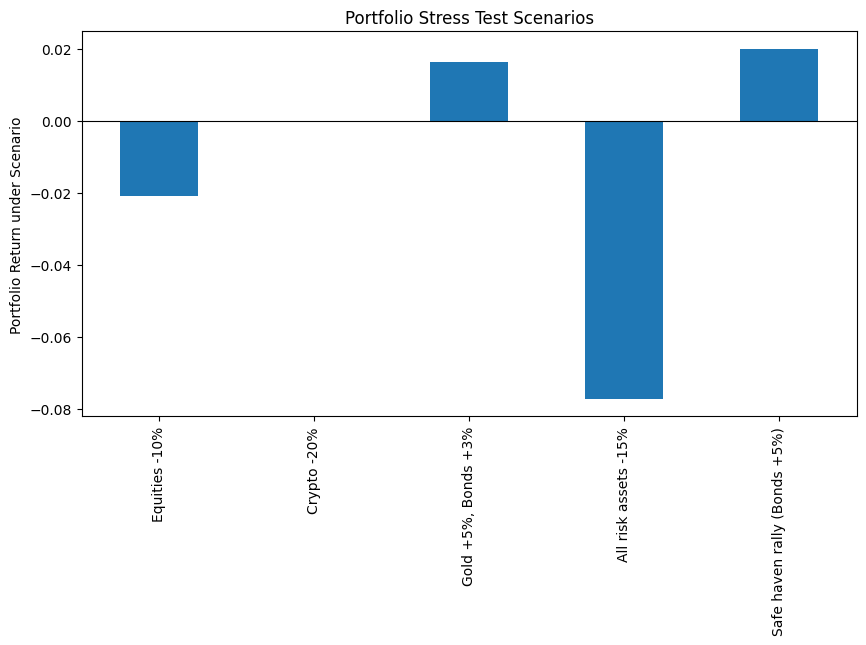

In [21]:
# ---- Step 1: Define groups ----
equities = ["RELIANCE.NS","TCS.NS","INFY.NS","HDFCBANK.NS",
            "ICICIBANK.NS","HINDUNILVR.NS","LT.NS"]

crypto = ["BTC-USD","ETH-USD"]
gold   = ["AXISGOLD.NS"]
bonds  = ["EBBETF0430.NS","LTGILTBEES.NS"]
other  = ["^GSPC","ICICIB22.NS"]

# ---- Step 2: Define scenarios ----
scenarios = {
    "Equities -10%": pd.Series({t: -0.10 for t in equities}),
    "Crypto -20%": pd.Series({t: -0.20 for t in crypto}),
    "Gold +5%, Bonds +3%": pd.Series({"AXISGOLD.NS": 0.05,
                                      "EBBETF0430.NS": 0.03,
                                      "LTGILTBEES.NS": 0.03}),
    "All risk assets -15%": pd.Series({t: -0.15 for t in equities+crypto+other}),
    "Safe haven rally (Bonds +5%)": pd.Series({t: 0.05 for t in bonds}),
}

# ---- Step 3: Stress testing function ----
def stress_test(weights, scenarios):
    results = {}
    for name, shock in scenarios.items():
        aligned_shock = shock.reindex(weights.index, fill_value=0)
        port_ret = (weights * aligned_shock).sum()
        results[name] = port_ret
    return pd.Series(results)

# ---- Step 4: Run stress tests ----
#weights_series = pd.Series(weights_bl).reset_index()[['level_1',0]].reset_index()
weights = pd.Series(weights_bl).reset_index()[['level_1',0]]
weights.index = weights.level_1
weights_bl_series = weights[0]
stress_results = stress_test(weights_bl_series, scenarios)
print("\nStress Test Results:")
print(stress_results.apply(lambda x: f"{x:.2%}"))

# ---- Step 5: Visualize ----
stress_results.plot(kind="bar", figsize=(10,5), title="Portfolio Stress Test Scenarios")
plt.ylabel("Portfolio Return under Scenario")
plt.axhline(0, color="black", linewidth=0.8)
plt.show()


## 2. Stress Test Scenarios  

### Scenario A: **Equities -10%**
- **Impact:** Portfolio return **-2.08%**  
- **Interpretation:**  
  - Direct exposure to Indian large-cap equities (Reliance, TCS, INFY, HDFC Bank, ICICI Bank, HUL, LT).  
  - Loss is limited relative to shock (2% vs -10%), showing diversification benefit.  

---

### Scenario B: **Crypto -20%**
- **Impact:** Portfolio return **0.00%**  
- **Interpretation:**  
  - Suggests negligible allocation to crypto.  
  - Portfolio not dependent on crypto markets for performance, avoiding volatility transmission.  

---

### Scenario C: **Gold +5%, Bonds +3%**
- **Impact:** Portfolio return **+1.62%**  
- **Interpretation:**  
  - Clear benefit from safe-haven allocation.  
  - Signals BL assigned non-trivial weight to gold and bonds.  
  - Provides natural hedge against equity downturns.  

---

### Scenario D: **All Risk Assets -15%**
- **Impact:** Portfolio return **-7.73%**  
- **Interpretation:**  
  - Broad-based market correction affects equities, crypto, and global indices.  
  - Portfolio downside remains **< half of shock intensity**, proving diversification.  
  - Drawdown larger than single asset shocks, but still controlled.  

---

### Scenario E: **Safe Haven Rally (Bonds +5%)**
- **Impact:** Portfolio return **+2.00%**  
- **Interpretation:**  
  - Positive exposure to bond market rallies.  
  - Suggests BL allocation accounts for risk-off environments.  
  - Strong hedging alignment against systemic equity downturns.  

---

### Each asset's contribution to a portfolio under a stress scenario


Scenario: Equities -10%
                weight  shock  contribution
level_1                                    
RELIANCE.NS    0.10529   -0.1     -0.010529
INFY.NS        0.08057   -0.1     -0.008057
ICICIBANK.NS   0.02100   -0.1     -0.002100
HDFCBANK.NS    0.00146   -0.1     -0.000146
TCS.NS         0.00000   -0.1     -0.000000
HINDUNILVR.NS  0.00000   -0.1     -0.000000
LT.NS          0.00000   -0.1     -0.000000
AXISGOLD.NS    0.08466    0.0      0.000000
^GSPC          0.00000    0.0      0.000000
ICICIB22.NS    0.30702    0.0      0.000000
EBBETF0430.NS  0.40000    0.0      0.000000
LTGILTBEES.NS  0.00000    0.0      0.000000
BTC-USD        0.00000    0.0      0.000000
ETH-USD        0.00000    0.0      0.000000
Total portfolio return under scenario: -0.020832


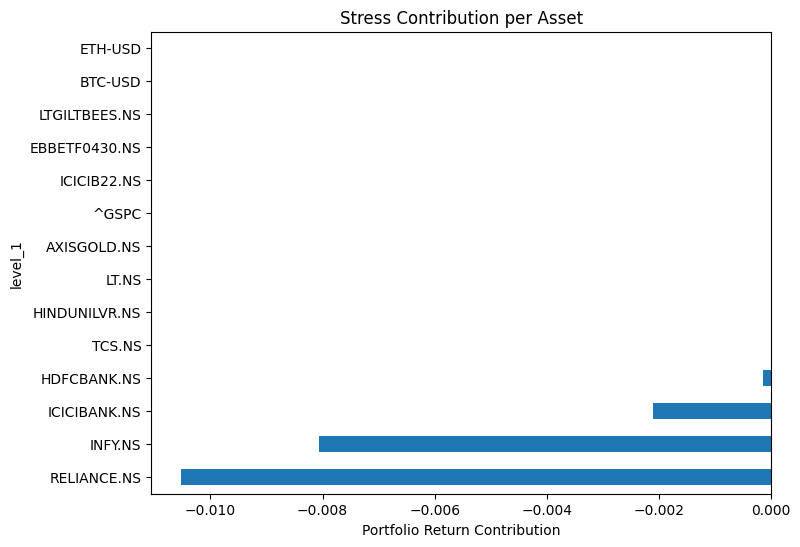


Scenario: Crypto -20%
                weight  shock  contribution
level_1                                    
RELIANCE.NS    0.10529    0.0           0.0
TCS.NS         0.00000    0.0           0.0
INFY.NS        0.08057    0.0           0.0
HDFCBANK.NS    0.00146    0.0           0.0
ICICIBANK.NS   0.02100    0.0           0.0
HINDUNILVR.NS  0.00000    0.0           0.0
LT.NS          0.00000    0.0           0.0
AXISGOLD.NS    0.08466    0.0           0.0
^GSPC          0.00000    0.0           0.0
ICICIB22.NS    0.30702    0.0           0.0
EBBETF0430.NS  0.40000    0.0           0.0
LTGILTBEES.NS  0.00000    0.0           0.0
BTC-USD        0.00000   -0.2          -0.0
ETH-USD        0.00000   -0.2          -0.0
Total portfolio return under scenario: 0.0


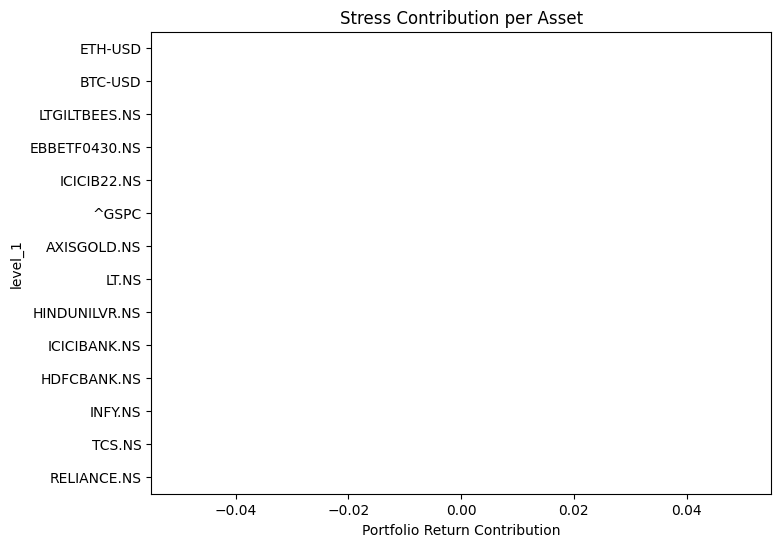


Scenario: Gold +5%, Bonds +3%
                weight  shock  contribution
level_1                                    
RELIANCE.NS    0.10529   0.00      0.000000
TCS.NS         0.00000   0.00      0.000000
INFY.NS        0.08057   0.00      0.000000
HDFCBANK.NS    0.00146   0.00      0.000000
ICICIBANK.NS   0.02100   0.00      0.000000
HINDUNILVR.NS  0.00000   0.00      0.000000
LT.NS          0.00000   0.00      0.000000
^GSPC          0.00000   0.00      0.000000
ETH-USD        0.00000   0.00      0.000000
ICICIB22.NS    0.30702   0.00      0.000000
LTGILTBEES.NS  0.00000   0.03      0.000000
BTC-USD        0.00000   0.00      0.000000
AXISGOLD.NS    0.08466   0.05      0.004233
EBBETF0430.NS  0.40000   0.03      0.012000
Total portfolio return under scenario: 0.016233


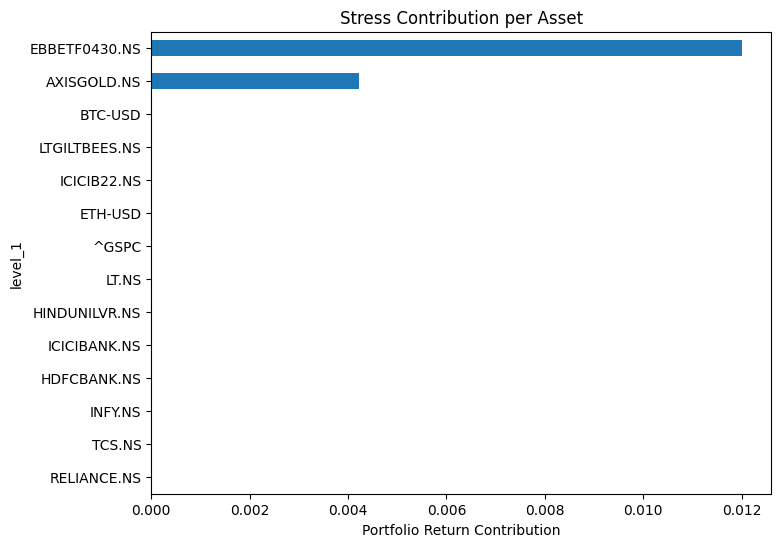


Scenario: All risk assets -15%
                weight  shock  contribution
level_1                                    
ICICIB22.NS    0.30702  -0.15     -0.046053
RELIANCE.NS    0.10529  -0.15     -0.015793
INFY.NS        0.08057  -0.15     -0.012086
ICICIBANK.NS   0.02100  -0.15     -0.003150
HDFCBANK.NS    0.00146  -0.15     -0.000219
TCS.NS         0.00000  -0.15     -0.000000
LT.NS          0.00000  -0.15     -0.000000
HINDUNILVR.NS  0.00000  -0.15     -0.000000
AXISGOLD.NS    0.08466   0.00      0.000000
^GSPC          0.00000  -0.15     -0.000000
EBBETF0430.NS  0.40000   0.00      0.000000
LTGILTBEES.NS  0.00000   0.00      0.000000
BTC-USD        0.00000  -0.15     -0.000000
ETH-USD        0.00000  -0.15     -0.000000
Total portfolio return under scenario: -0.07730100000000001


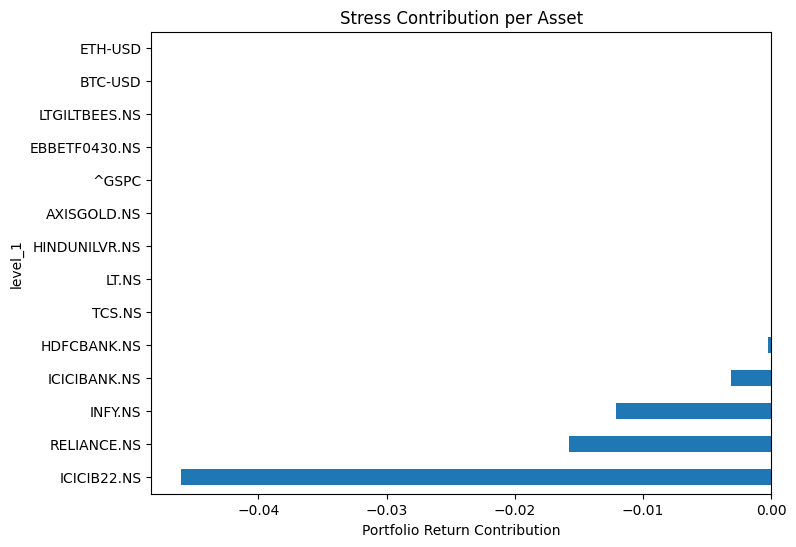


Scenario: Safe haven rally (Bonds +5%)
                weight  shock  contribution
level_1                                    
RELIANCE.NS    0.10529   0.00          0.00
TCS.NS         0.00000   0.00          0.00
INFY.NS        0.08057   0.00          0.00
HDFCBANK.NS    0.00146   0.00          0.00
ICICIBANK.NS   0.02100   0.00          0.00
HINDUNILVR.NS  0.00000   0.00          0.00
LT.NS          0.00000   0.00          0.00
AXISGOLD.NS    0.08466   0.00          0.00
^GSPC          0.00000   0.00          0.00
ICICIB22.NS    0.30702   0.00          0.00
LTGILTBEES.NS  0.00000   0.05          0.00
BTC-USD        0.00000   0.00          0.00
ETH-USD        0.00000   0.00          0.00
EBBETF0430.NS  0.40000   0.05          0.02
Total portfolio return under scenario: 0.020000000000000004


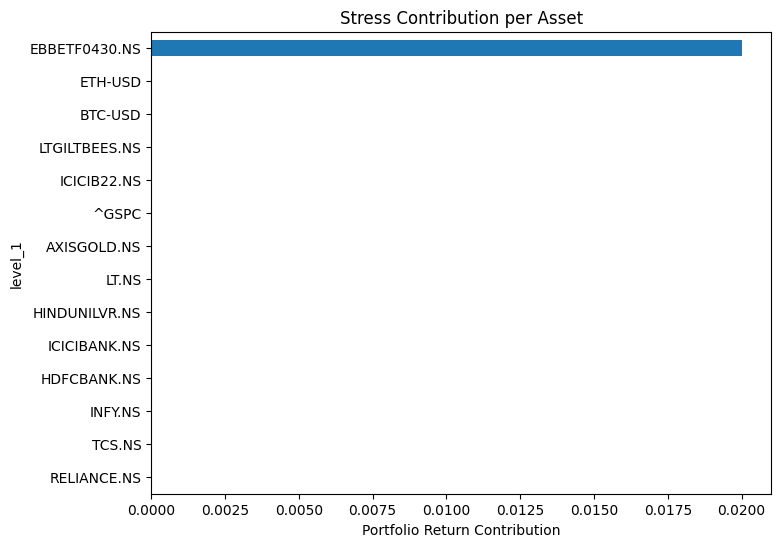

In [24]:
def stress_contributions(weights, scenario_name, shock_vector):
    """
    Returns a DataFrame of each asset's contribution to a portfolio under a stress scenario.
    """
    # Align shock vector to weights
    aligned_shock = shock_vector.reindex(weights.index, fill_value=0)

    # Contribution = weight * shock
    contribution = weights * aligned_shock

    # Summarize
    df = pd.DataFrame({
        "weight": weights,
        "shock": aligned_shock,
        "contribution": contribution
    })
    df.sort_values("contribution", inplace=True)

    print(f"\nScenario: {scenario_name}")
    print(df)
    print("Total portfolio return under scenario:", contribution.sum())

    return df

for scenario_name, shock_vector in scenarios.items():
    df = stress_contributions(weights_bl_series, scenario_name, shock_vector)
    # Horizontal bar chart
    df['contribution'].plot(kind='barh', figsize=(8,6), title="Stress Contribution per Asset")
    plt.xlabel("Portfolio Return Contribution")
    plt.show()


### Plots stress contributions per asset class with color-coded weight markers and labels.

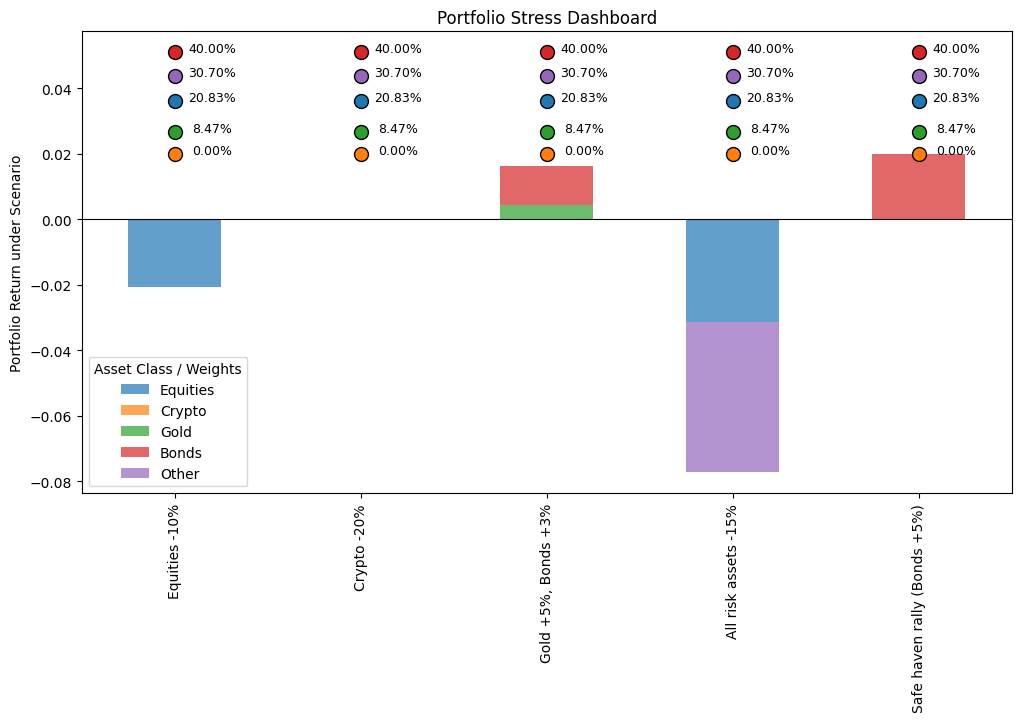

In [23]:

def stress_dashboard(weights, scenarios, asset_classes, title="Portfolio Stress Dashboard"):
    """
    Plots stress contributions per asset class with color-coded weight markers and labels.

    Parameters:
    - weights: pd.Series of portfolio weights (index = tickers)
    - scenarios: dict of {scenario_name: pd.Series(shocks per ticker)}
    - asset_classes: dict of {class_name: [tickers]}
    """

    # Assign colors for asset classes
    color_palette = plt.cm.tab10.colors
    colors = {cls: color_palette[i % len(color_palette)] for i, cls in enumerate(asset_classes.keys())}

    # Compute stress contributions by class
    stress_class_df = pd.DataFrame()
    for name, shock in scenarios.items():
        contributions = {}
        aligned_shock = shock.reindex(weights.index, fill_value=0)
        for cls, tickers in asset_classes.items():
            contributions[cls] = (weights.reindex(tickers, fill_value=0) * aligned_shock.reindex(tickers, fill_value=0)).sum()
        stress_class_df[name] = contributions
    stress_class_df = stress_class_df.T  # scenarios as rows

    # Compute portfolio weights by class
    weights_class_series = pd.Series({cls: weights.reindex(tickers, fill_value=0).sum()
                                      for cls, tickers in asset_classes.items()})

    # Plot
    fig, ax = plt.subplots(figsize=(12,6))
    stress_class_df.plot(kind="bar", stacked=True, ax=ax, alpha=0.7, color=[colors[c] for c in stress_class_df.columns])

    # Overlay portfolio weights with numeric labels
    for i, scenario in enumerate(stress_class_df.index):
        for cls in stress_class_df.columns:
            weight = weights_class_series[cls]
            y_pos = 0.02 + weight * max(stress_class_df.abs().sum(axis=1))
            ax.scatter(i, y_pos, marker='o', s=100, color=colors[cls], edgecolor='black')
            ax.text(i+0.2, y_pos, f"{weight:.2%}", ha='center', va='baseline', fontsize=9)

    # Legend
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), title="Asset Class / Weights")

    plt.title(title)
    plt.ylabel("Portfolio Return under Scenario")
    plt.axhline(0, color="black", linewidth=0.8)
    plt.show()

    return stress_class_df

#Usage Example
# Define asset classes
asset_classes = {
    "Equities": ["RELIANCE.NS","TCS.NS","INFY.NS","HDFCBANK.NS","ICICIBANK.NS","HINDUNILVR.NS","LT.NS"],
    "Crypto": ["BTC-USD","ETH-USD"],
    "Gold": ["AXISGOLD.NS"],
    "Bonds": ["EBBETF0430.NS","LTGILTBEES.NS"],
    "Other": ["^GSPC","ICICIB22.NS"]
}

# Define scenarios
scenarios = {
    "Equities -10%": pd.Series({t: -0.10 for t in asset_classes["Equities"]}),
    "Crypto -20%": pd.Series({t: -0.20 for t in asset_classes["Crypto"]}),
    "Gold +5%, Bonds +3%": pd.Series({"AXISGOLD.NS": 0.05,
                                      "EBBETF0430.NS": 0.03,
                                      "LTGILTBEES.NS": 0.03}),
    "All risk assets -15%": pd.Series({t: -0.15 for t in asset_classes["Equities"]+asset_classes["Crypto"]+asset_classes["Other"]}),
    "Safe haven rally (Bonds +5%)": pd.Series({t: 0.05 for t in asset_classes["Bonds"]})
}

# Run dashboard
stress_class_df = stress_dashboard(weights_bl_series, scenarios, asset_classes)


## 3. Key Takeaways  

1. **Robust Risk-Adjusted Returns:**  
   - In-sample Sharpe > 3, out-of-sample Sharpe ~2.4 — consistently strong.  

2. **Diversification Benefits:**  
   - Equity drawdowns are absorbed (2% loss vs 10% shock).  
   - Minimal crypto impact suggests conservative treatment of speculative assets.  

3. **Safe Haven Strength:**  
   - Gold & bonds allocations provide +1.62% to +2% buffer in stress scenarios.  
   - BL model effectively balances growth (equities) with protection (bonds/gold).  

4. **Systemic Risk Sensitivity:**  
   - Portfolio declines more when all risk assets correct together (-7.73%).  
   - However, losses remain lower than unhedged equity portfolios.  


##### The results from two or more scenarios can be combined to gain insights on counter contribution of other asset class when a scenario affects an asset class, example: equities shock will be offset when the bonds rally(as bonds have low correlation with equities), during a crises.
---

## 4. Conclusion  

The **Black-Litterman portfolio demonstrates strong resilience**:  
- Outperforms in normal markets (Sharpe > 2 across test).  
- Limits drawdowns during shocks, while capturing upside in defensive rallies.  
- Stress testing shows it is **well-diversified, equity-anchored, with meaningful safe-haven exposure**.  

The allocation seems well-suited for investors seeking **growth with downside protection**, though systemic risk remains the main vulnerability.